In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

#3d processing
import pywavefront
import trimesh

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Data collection and preparaion

In [2]:
def collect_data(dir_path, split_name):
    data = []

    for shape in os.listdir(dir_path):
        shape_path = os.path.join(dir_path, shape)
        if os.path.isdir(shape_path):
            split_path = os.path.join(shape_path, split_name)
            if os.path.isdir(split_path):
                file_data = [{'filename': os.path.join(split_path, file), 'label':file.split('.')[0]} for file in os.listdir(split_path) if file.endswith('.obj')]
                data.extend(file_data)

    df = pd.DataFrame(data)
    return df

dir_path = 'data'
train = collect_data(dir_path, 'train')
test = collect_data(dir_path, 'test')
valid = collect_data(dir_path, 'valid')

Encode data

In [3]:
encoder = LabelEncoder()
encoder.fit(train['label'])
train['label'] = encoder.transform(train['label'])
test['label'] = encoder.transform(test['label'])
valid['label'] = encoder.transform(valid['label'])

with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

3d visualisation

In [4]:
import open3d as o3d

def visualise(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    voxel_grid=o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size=0.01)

    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Points', width=800, height=600)

    vis.add_geometry(voxel_grid)

    vis.run()
    vis.destroy_window()


obj = pywavefront.Wavefront('data/torus/train/Torus.1541.obj')
#visualise(obj.vertices)

Unimplemented OBJ format statement 's' on line 's off'


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Dataset implementation for torch

In [5]:
class PointCloudDataset(Dataset):
    def __init__(self, df, num_points):
        self.df = df
        self.num_points = num_points

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df['filename'][idx]
        label = self.df['label'][idx]
        mesh = trimesh.load(file_path)
        points = mesh.vertices
        # Sample a fixed number of points from the point cloud
        points, label = self.downsample(points, label)
        # Normalize the point cloud
        points = (points - np.mean(points, axis=0)) / np.std(points, axis=0)
        points = torch.from_numpy(points).type(torch.float32)
        label = torch.tensor(label).type(torch.LongTensor)
        return points, label

    def downsample(self, points, targets):
        if len(points) > self.num_points:
            choice = np.random.choice(len(points), self.num_points, replace=False)
        else:
            # case when there are less points than the desired number
            choice = np.random.choice(len(points), self.num_points, replace=True)
        points = points[choice, :]
        targets = targets

        return points, targets

In [6]:
train_dataset = PointCloudDataset(train, 1024)
test_dataset = PointCloudDataset(test, 1024)
valid_dataset = PointCloudDataset(valid, 1024)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

PointNet implementation

In [7]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, input):
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

In [8]:
class PointNetBackbone(nn.Module):
    def __init__(self, num_points=1024, num_feats=1024):

        super(PointNetBackbone, self).__init__()

        self.num_points = num_points
        self.num_feats = num_feats

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(3)
        self.tnet2 = Tnet(64)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_feats, kernel_size=1)

        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)


    def forward(self, x):

        bs = x.shape[0]

        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)


        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get feature vector and critical indexes
        features, critical_indexes = self.max_pool(x)
        features = features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        return features, critical_indexes, A_feat

In [9]:
class PointNet(nn.Module):
    def __init__(self, classes = 6):
        super().__init__()
        self.transform = PointNetBackbone()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):
        x, crit_idxs, A_feat = self.transform(input)
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x, crit_idxs, A_feat

In [10]:
class PointNetLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, reg_weight=0, size_average=True):
        super(PointNetLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reg_weight = reg_weight
        self.size_average = size_average

        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)


    def forward(self, predictions, targets, A=None):

        bs = predictions.size(0)

        ce_loss = self.cross_entropy_loss(predictions, targets)

        pn = F.softmax(predictions, dim = 0)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # get regularization
        if self.reg_weight > 0:
            I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1) # .to(device)
            if A.is_cuda: I = I.cuda()
            reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))
            reg = self.reg_weight*reg/bs
        else:
            reg = 0

        loss = ((1 - pn)**self.gamma * ce_loss)
        if self.size_average: return loss.mean() + reg
        else: return loss.sum() + reg

test on one batch

In [12]:
points, targets = next(iter(train_loader))
classifier = PointNet(6)
classifier.load_state_dict(torch.load('models/modelv1'))
out, _, _ = classifier(points.transpose(2,1))
out.shape

torch.Size([32, 6])

Training

In [ ]:
EPOCHS = 10
LR = 0.0001
REG_WEIGHT = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alpha = np.ones(6)
gamma = 2

optimizer = torch.optim.Adam(classifier.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01,
                                              step_size_up=2000, cycle_momentum=False)
criterion = PointNetLoss(alpha=alpha, gamma=gamma, reg_weight=REG_WEIGHT).to(device)

classifier = classifier.to(device)

In [ ]:
def train_test(classifier, dataloader, num_batch, epoch, split='train'):
    _loss = []
    _accuracy = []

    total_test_targets = []
    total_test_preds = []
    for i, (points, targets) in enumerate(dataloader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)

        optimizer.zero_grad()
        preds, _, A = classifier(points)
        loss = criterion(preds, targets, A)

        if split == 'train':
            loss.backward()
            optimizer.step()
            scheduler.step()

        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(32)

        _loss.append(loss.item())
        _accuracy.append(accuracy)

        if split == 'test':
            total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
            total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 10 == 0:
            print(f'\t [{epoch}: {i}/{num_batch}] ' \
                  + f'{split} loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f}')

    epoch_loss = np.mean(_loss)
    epoch_accuracy = np.mean(_accuracy)

    print(f'Epoch: {epoch} - {split} Loss: {epoch_loss:.4f} ' \
          + f'- {split} Accuracy: {epoch_accuracy:.4f} ' \
          + f'- {split}')

    if split == 'test':
        return epoch_loss, epoch_accuracy, total_test_targets, total_test_preds
    else:
        return epoch_loss, epoch_accuracy


In [ ]:
num_train_batch = int(np.ceil(len(train_dataset)/32))
num_valid_batch = int(np.ceil(len(test_dataset)/32))

train_metrics = []
valid_metrics = []

for epoch in range(1, 10):

    classifier = classifier.train()

    _train_metrics = train_test(classifier, train_loader,
                                num_train_batch, epoch,
                                split='train')
    train_metrics.append(_train_metrics)

    with torch.no_grad():

        classifier = classifier.eval()

        _valid_metrics = train_test(classifier, test_loader,
                                    num_valid_batch, epoch,
                                    split='test')
        valid_metrics.append(_valid_metrics)



In [13]:
predictions = []
labels = []
acc = []

for i, (points, targets) in enumerate(valid_loader, 0):
    with torch.no_grad():
        classifier.eval().to('cpu')

        points = points.transpose(2,1)
        targets = targets.squeeze()

        preds, _, A = classifier(points)
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1)

        correct = (pred_choice == targets.data).sum()
        accuracy = correct.item()/float(32)

        predictions.extend(pred_choice)
        labels.extend(targets.data)


NameError: name 'train_metrics' is not defined

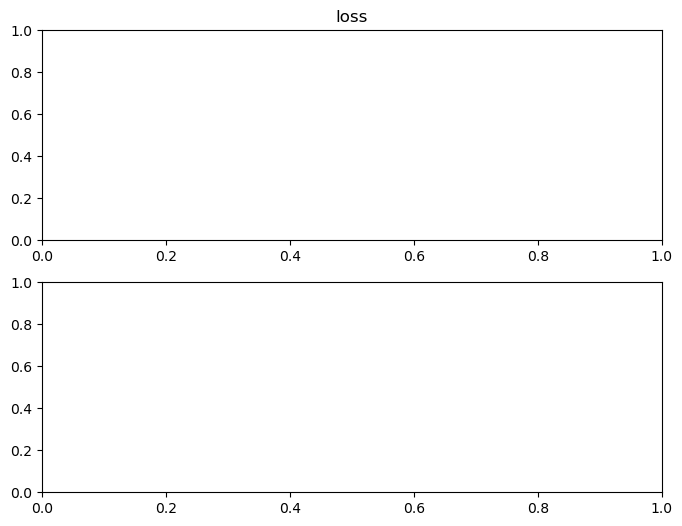

In [14]:
metric_names = ['loss', 'accuracy']
_, ax = plt.subplots(len(metric_names), 1, figsize=(8, 6))

for i, m in enumerate(metric_names):
    ax[i].set_title(m)
    ax[i].plot([t[i] for t in train_metrics], label='train')
    ax[i].plot([t[i] for t in valid_metrics], label='test')
    ax[i].legend()

plt.subplots_adjust(wspace=0., hspace=0.35)
plt.show()

Check accuracy and another metrics

In [15]:
print(classification_report(encoder.inverse_transform(labels), encoder.inverse_transform(predictions)))

              precision    recall  f1-score   support

        Cone       0.98      1.00      0.99        50
        Cube       0.96      1.00      0.98        50
    Cylinder       1.00      0.98      0.99        50
       Plane       1.00      0.96      0.98        50
      Sphere       1.00      1.00      1.00        50
       Torus       1.00      1.00      1.00        50

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [ ]:
cf_matrix = pd.DataFrame(columns= encoder.classes_, index=encoder.classes_, data = confusion_matrix(encoder.inverse_transform(labels), encoder.inverse_transform(predictions)))
cf_matrix

save model

In [ ]:
path = "models/modelv1"
torch.save(classifier.state_dict(), path)